# Mu2e Tracker Calibration

The Mu2e tracker consists of over 23,000+ straws, each of which exhibits variance in the normalization of recorded energy deposition values for minimum ionizing particles due to nonuniformities in the backend electronics. Calibration at Mu2e aims to address and correct for this variance. In this project, I focused on a simplified scenario, considering variance across the 36 panels in a simulation of high-momentum cosmic muons traveling in straight trajectories through the tracker. The approach involved identifying an invariant energy-related quantity across the 36 planes. We selected the average of the average dE/dx across the planes, as for these cosmic muons, the energy deposited per unit path length should remain constant across the 36 planes, making it an ideal reference for calibration. By calculating the ratio of each plane's average dE/dx to this reference and scaling the energy deposition values accordingly, we developed a method that can be generalized to calibrate the energy deposition values for the tracker’s 23,000+ individual straws.

Let us first important the necessary Python libraries.

In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

Enter the path to the desired ROOT file containing the simulated and Monte Carlo truth values.

In [3]:
files = ["/home/online1/rbonventre/energycalibration/trkana.planes.0.root"]

Our first goal is to calculate the energy deposited per unit distance traveled by an electron in a given straw. To do this, we naturally need the following parameters: rdoca (distance of closest approach from the fit reference), state (state of the hit in the last fit iteration), wdot (cosine of the angle between the wire and the local track direction), plane (plane of the hit), and edep (reconstructed estimate of the energy deposited by the particle in MeV using the ADC waveform).

In [4]:
data_fields = ["rdoca", "state", "wdot", "plane", "edep"]

We create two dictionaries to store the simulation and Monte Carlo truth values and append information to them using the uproot iterate process.

In [5]:
a = {field: [] for field in data_fields}
amc = {"edep": []}

for batch in uproot.iterate(files, filter_name="/kl|kltsh|kltshmc/i"):
    cutStatus = ak.sum(batch["kl.status"], axis=1) == 1
    for field in data_fields:
        a[field].append(ak.flatten(ak.flatten(batch["kltsh"][field][cutStatus])).to_numpy())
    amc["edep"].append(ak.flatten(ak.flatten(batch["kltshmc"]["edep"][ak.local_index(batch["kltshmc"]["edep"]) < ak.num(batch["kltsh"]["edep"],axis=2)][cutStatus])).to_numpy())
    break

for field in a:
    a[field] = np.concatenate(a[field])
amc["edep"] = np.concatenate(amc["edep"])

Via some simple geometry, we can calculate the pathlength for each track and store them in an array. Note that we perform a cut to ensure we only consider tracks with an accurate radial position.

In [6]:
pathLength = []
hitCut = (np.abs(a["state"]) == 1) & (np.abs(a["rdoca"]) < 2.5)
pathLength = np.abs((np.sqrt((6.25 - (a["rdoca"][hitCut])**2) / 4)) / (np.sin(np.arccos((a["wdot"][hitCut])))))

Our invariant value between planes will be the average of the average energy deposited per unit length of each plane. This makes sense, because across each plane, the ratio of energy deposited to distance traveled should be the same.

As such, we must calculate the average energy deposited per unit length of each plane, then calculate the invariant value, and ultimately scale the energy deposition values by the ratio between a plane's de/dx value and the invariant value. Then, to verify that this scaling process works, we can plot a histogram of the calibrated and uncalibrated edep values across all 36 planes.

But first, let us determine the lower bound of the path lengths that we actually want to consider when deriving this invariant quantity. Let us plot a histogram of pathlength across the 36 planes.

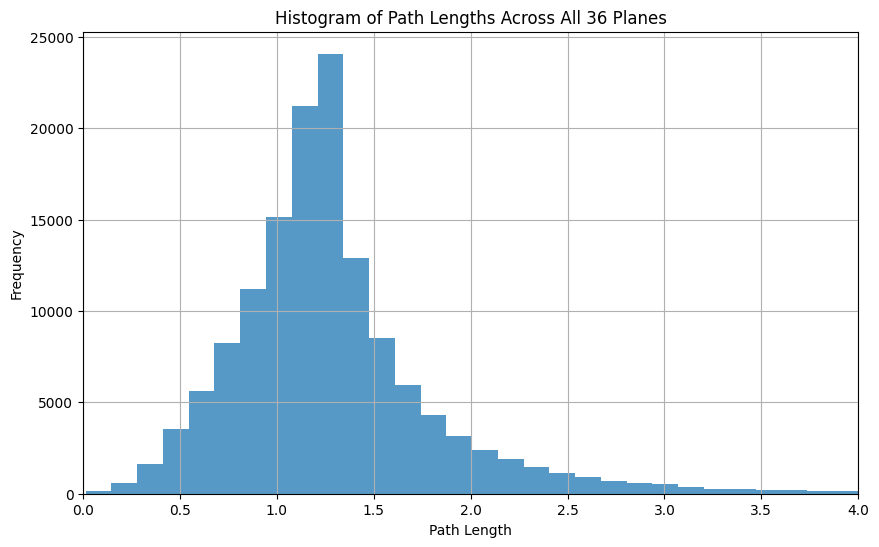

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(pathLength, bins=100, alpha=0.75)
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.title('Histogram of Path Lengths Across All 36 Planes')
plt.grid(True)
plt.xlim(0,4)
plt.show()

/tmp/ipykernel_1079293/4141312424.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


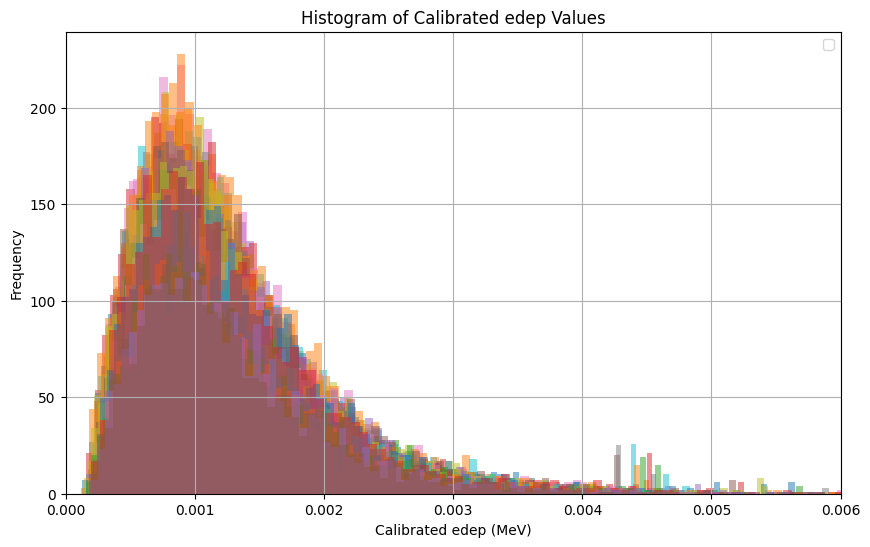

0.8867263


/tmp/ipykernel_1079293/4141312424.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


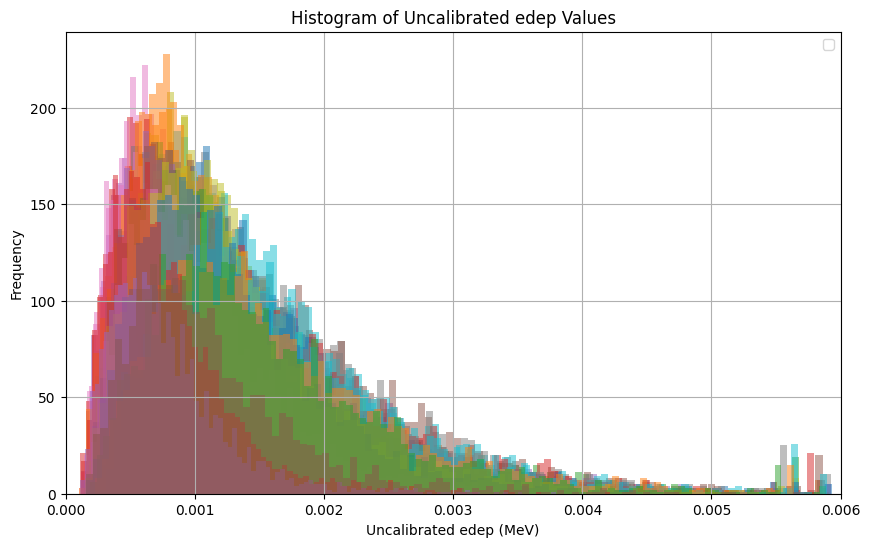

In [15]:
average_dedx_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    pathCut = pathLength >= 1.3
    de = a["edep"][hitCut]
    path = pathLength
    dedx = de[planeCut & pathCut]/path[planeCut & pathCut]
    average_dedx = np.mean(dedx)
    average_dedx_per_plane.append(average_dedx)

target_mean = np.mean(average_dedx_per_plane)
normalized_average_dedx_per_plane = [average_dedx / target_mean for average_dedx in average_dedx_per_plane]

scaled_edep_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    de = a["edep"][hitCut]
    scaled_de = de[planeCut] / normalized_average_dedx_per_plane[plane]
    scaled_edep_per_plane.append(scaled_de)

plt.figure(figsize=(10, 6))
for plane, scaled_de in enumerate(scaled_edep_per_plane):
    plt.hist(scaled_de, bins=100, alpha=0.5)
plt.xlabel('Calibrated edep (MeV)')
plt.ylabel('Frequency')
plt.title('Histogram of Calibrated edep Values')
plt.legend()
plt.grid(True)
plt.xlim(0.00, 0.006)
plt.show()

print(normalized_average_dedx_per_plane[0])

plt.figure(figsize=(10, 6))
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    unscaled_de = a["edep"][hitCut][planeCut]
    plt.hist(unscaled_de, bins=100, alpha=0.5)
plt.xlabel('Uncalibrated edep (MeV)')
plt.ylabel('Frequency')
plt.title('Histogram of Uncalibrated edep Values')
plt.legend()
plt.grid(True)
plt.xlim(0.00, 0.006)
plt.show()


We can further plot the ratio between the uncalibrated edep and mcedep values, and compare it to the plot of the ratio between the calibrated edep and mcedep values. In theory, the latter should be a Gaussian centered around 1, since the calibrated edep and mcedep values would be identical in a perfect scenario.

/tmp/ipykernel_1079293/2365769871.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


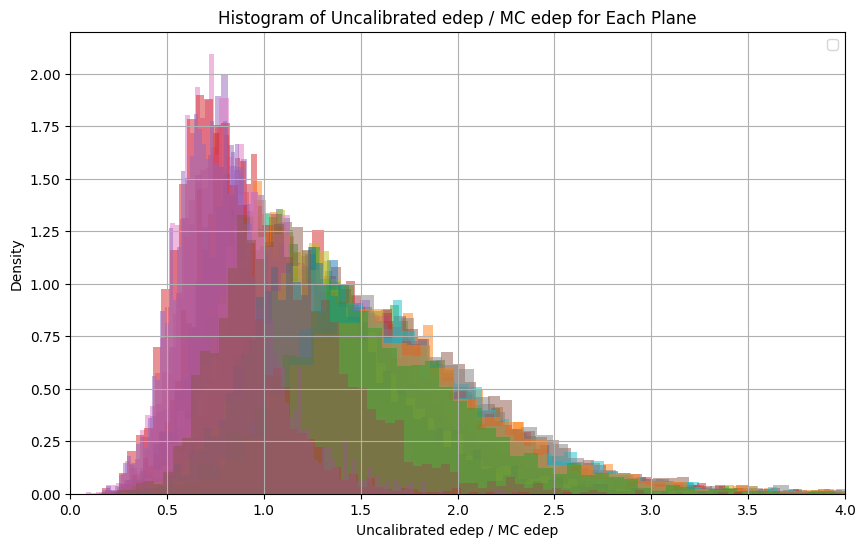

In [18]:
ratio_unscaled_edep_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    demc = amc["edep"][hitCut][planeCut]
    unscaled_de = a["edep"][hitCut][planeCut]
    ratio = unscaled_de / demc
    ratio_unscaled_edep_per_plane.append(ratio)

plt.figure(figsize=(10, 6))
for plane, ratio in enumerate(ratio_unscaled_edep_per_plane):
    plt.hist(ratio, bins=100, alpha=0.5, density=True)
plt.xlabel('Uncalibrated edep / MC edep')
plt.ylabel('Density')
plt.title('Histogram of Uncalibrated edep / MC edep for Each Plane')
plt.legend()
plt.xlim(0,4)
plt.grid(True)

# Sum the 36 individual histograms into one histogram
all_unscaled_de = np.concatenate(ratio_unscaled_edep_per_plane)

/tmp/ipykernel_1079293/2804878791.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


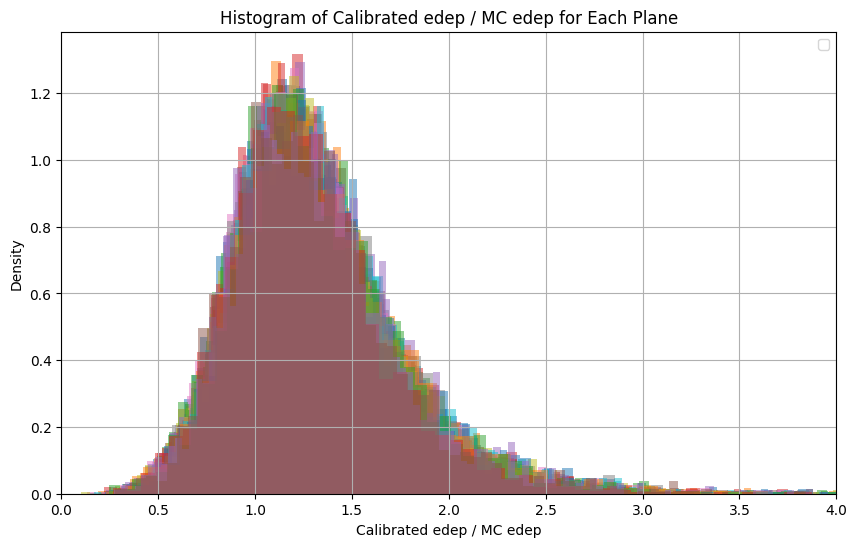

In [19]:
ratio_scaled_edep_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    demc = amc["edep"][hitCut][planeCut]
    scaled_de = scaled_edep_per_plane[plane]
    ratio = scaled_de / demc
    ratio_scaled_edep_per_plane.append(ratio)

plt.figure(figsize=(10, 6))
for plane, ratio in enumerate(ratio_scaled_edep_per_plane):
    plt.hist(ratio, bins=100, alpha=0.5, density=True)
plt.xlabel('Calibrated edep / MC edep')
plt.ylabel('Density')
plt.title('Histogram of Calibrated edep / MC edep for Each Plane')
plt.legend()
plt.grid(True)
plt.xlim(0,4)
plt.show()

# Sum the 36 individual histograms into one histogram
all_scaled_de = np.concatenate(ratio_scaled_edep_per_plane)


We can also sum the values of the 36 planes in each of these cases together, and then overlay the two resulting histograms. Calculating the RMS and standard deviation will provide us information as to whether the calibration was effective in decreasing variance across planes.

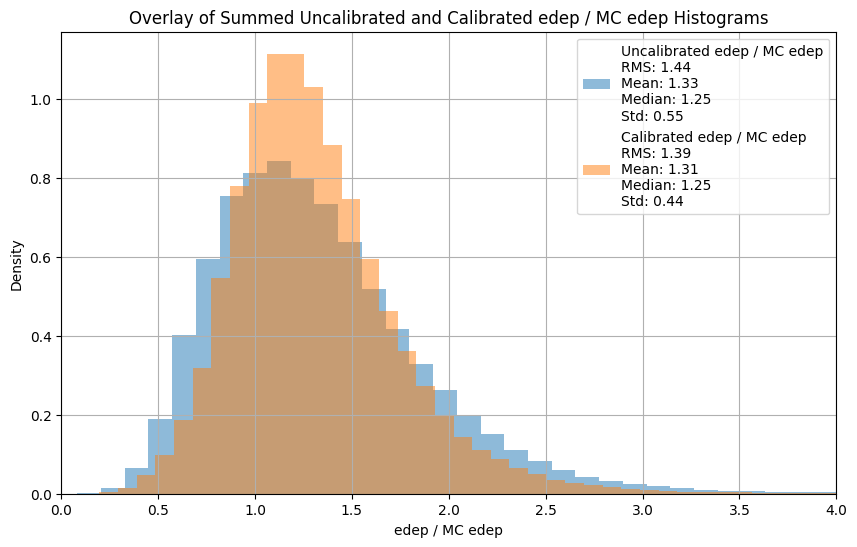

In [20]:
# Calculate statistics for unscaled data
unscaled_rms = np.sqrt(np.mean(np.square(all_unscaled_de)))
unscaled_mean = np.mean(all_unscaled_de)
unscaled_median = np.median(all_unscaled_de)
unscaled_std = np.std(all_unscaled_de)

# Calculate statistics for scaled data
scaled_rms = np.sqrt(np.mean(np.square(all_scaled_de)))
scaled_mean = np.mean(all_scaled_de)
scaled_median = np.median(all_scaled_de)
scaled_std = np.std(all_scaled_de)

# Plot the overlaid histograms
plt.figure(figsize=(10, 6))
plt.hist(all_unscaled_de, bins=100, alpha=0.5, label=f'Uncalibrated edep / MC edep\nRMS: {unscaled_rms:.2f}\nMean: {unscaled_mean:.2f}\nMedian: {unscaled_median:.2f}\nStd: {unscaled_std:.2f}', density=True)
plt.hist(all_scaled_de, bins=100, alpha=0.5, label=f'Calibrated edep / MC edep\nRMS: {scaled_rms:.2f}\nMean: {scaled_mean:.2f}\nMedian: {scaled_median:.2f}\nStd: {scaled_std:.2f}', density=True)
plt.xlabel('edep / MC edep')
plt.ylabel('Density')
plt.title('Overlay of Summed Uncalibrated and Calibrated edep / MC edep Histograms')
plt.legend()
plt.grid(True)
plt.xlim(0, 4)
plt.show()


We can clearly see that the distribution is more narrow and centered around 1 as it should.

The next natural step is to make a scatter plot of scaled edep vs mcedep for a particular plane and fit it to a line. We then expect a slope of 1, and can consider the range of scaled edep values that are properly scaled using this calibration method.

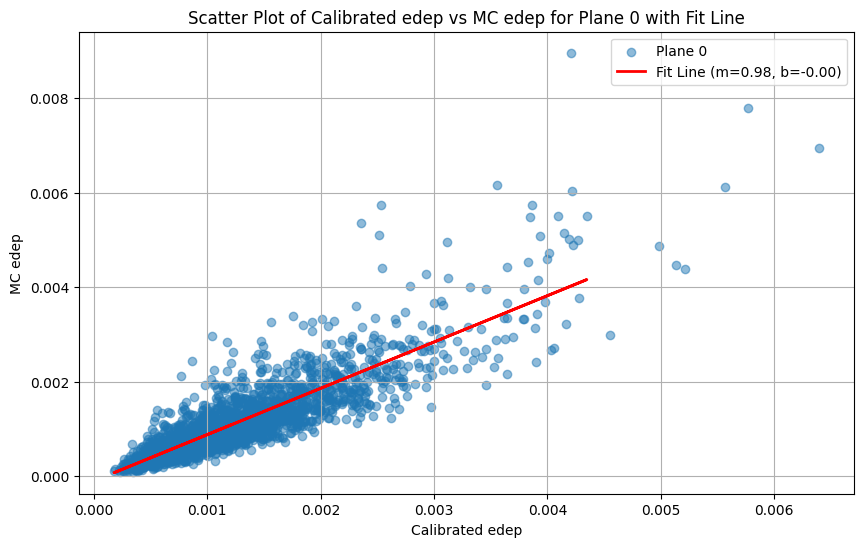

Minimum value in filtered_scaled_de: 0.00017650311929173768
Maximum value in filtered_scaled_de: 0.004346899222582579


In [22]:
plt.figure(figsize=(10, 6))
plane = 0
scaled_de = scaled_edep_per_plane[plane]
demc = amc["edep"][hitCut][a["plane"][hitCut] == plane]

min_scaled_de = 0
max_scaled_de = 0.0045
filtered_scaled_de = [de for de in scaled_de if min_scaled_de <= de <= max_scaled_de]
filtered_demc = [demc[i] for i, de in enumerate(scaled_de) if min_scaled_de <= de <= max_scaled_de]

m, b = np.polyfit(filtered_scaled_de, filtered_demc, 1)
plt.scatter(scaled_de, demc, alpha=0.5, label=f'Plane {plane}')
plt.plot(filtered_scaled_de, m*np.array(filtered_scaled_de) + b, color='red', linewidth=2, label=f'Fit Line (m={m:.2f}, b={b:.2f})')
plt.xlabel('Calibrated edep')
plt.ylabel('MC edep')
plt.title('Scatter Plot of Calibrated edep vs MC edep for Plane 0 with Fit Line')
plt.legend()
plt.grid(True)
plt.show()
print(f"Minimum value in filtered_scaled_de: {min(filtered_scaled_de)}")
print(f"Maximum value in filtered_scaled_de: {max(filtered_scaled_de)}")


In plane 0 for example, the range of well-fitted scaled edep values is 0.000 to 0.0045. We can convert this back to the original edep values to see the range of edep values that this calibration method works best on.

In [11]:
original_de_values = [de * normalized_average_dedx_per_plane[plane] for de in filtered_scaled_de]
print(f"Minimum value in original_de_values: {min(original_de_values)}")
print(f"Maximum value in original_de_values: {max(original_de_values)}")

Minimum value in original_de_values: 0.00015650996647309512
Maximum value in original_de_values: 0.00385450990870595


We can compare this to the scatter plot of unscaled edep vs. mcedep to see if our slope value improves (i.e. is closer to 1).

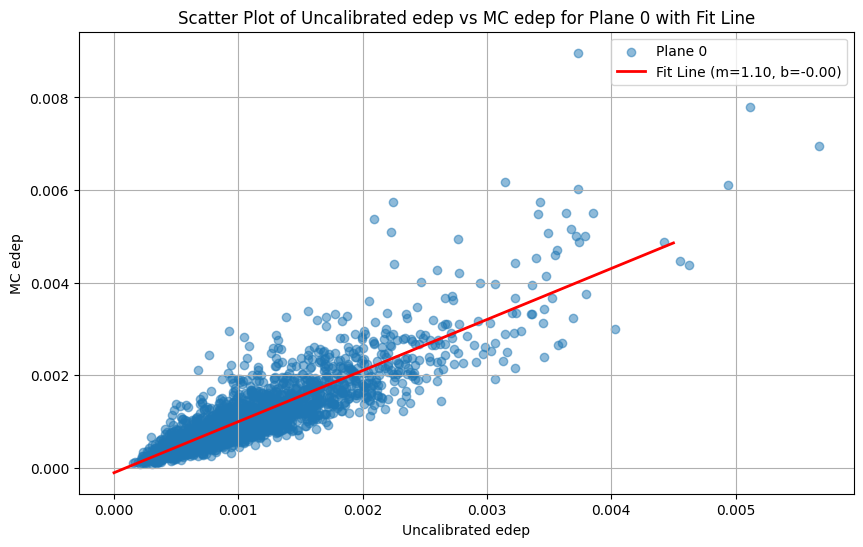

In [26]:
plt.figure(figsize=(10, 6))
plane = 0
unscaled_de = a["edep"][hitCut][a["plane"][hitCut] == plane]
demc = amc["edep"][hitCut][a["plane"][hitCut] == plane]

min_unscaled_de = 0
max_unscaled_de = 0.0045
filtered_unscaled_de = [de for de in unscaled_de if min_unscaled_de <= de <= max_unscaled_de]
filtered_demc = [demc[i] for i, de in enumerate(unscaled_de) if min_unscaled_de <= de <= max_unscaled_de]

m, b = np.polyfit(filtered_unscaled_de, filtered_demc, 1)
plt.scatter(unscaled_de, demc, alpha=0.5, label=f'Plane {plane}')
plt.plot([min_unscaled_de, max_unscaled_de], m*np.array([min_unscaled_de, max_unscaled_de]) + b, color='red', linewidth=2, label=f'Fit Line (m={m:.2f}, b={b:.2f})')
plt.xlabel('Uncalibrated edep')
plt.ylabel('MC edep')
plt.title('Scatter Plot of Uncalibrated edep vs MC edep for Plane 0 with Fit Line')
plt.legend()
plt.grid(True)
plt.show()

As is evident, the fitted line has a slope closer to 1 in our scaled case, implying that our calibration improves the overall data.

We can extend this analysis to all planes and create two histograms, one for the slope values of scaled edep vs. mcedep and one for the slope values of unscaled edep vs. mcedep.

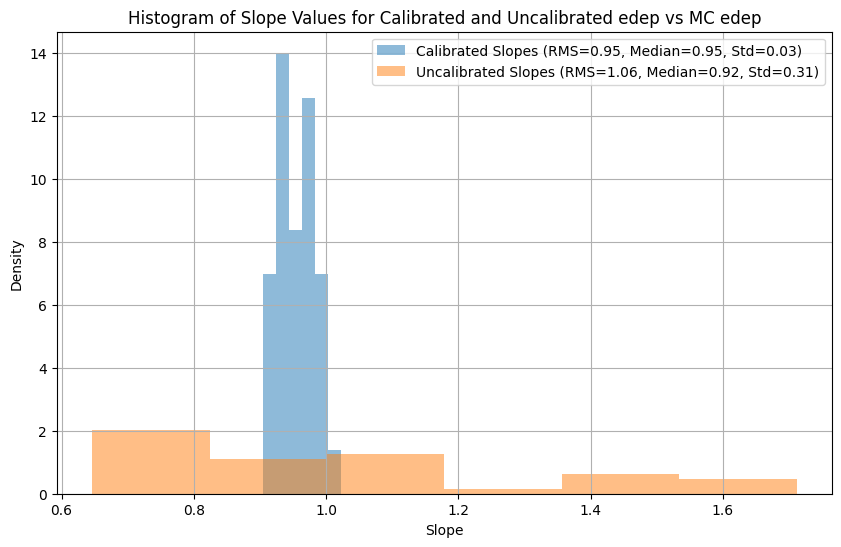

In [25]:
scaled_slopes = []
unscaled_slopes = []

for plane in range(36):
    # Scaled edep vs mcedep
    scaled_de = scaled_edep_per_plane[plane]
    demc = amc["edep"][hitCut][a["plane"][hitCut] == plane]
    min_scaled_de = 0
    max_scaled_de = 0.0045
    filtered_scaled_de = [de for de in scaled_de if min_scaled_de <= de <= max_scaled_de]
    filtered_demc = [demc[i] for i, de in enumerate(scaled_de) if min_scaled_de <= de <= max_scaled_de]
    m, b = np.polyfit(filtered_scaled_de, filtered_demc, 1)
    scaled_slopes.append(m)
    
    # Unscaled edep vs mcedep
    unscaled_de = a["edep"][hitCut][a["plane"][hitCut] == plane]
    demc = amc["edep"][hitCut][a["plane"][hitCut] == plane]
    min_unscaled_de = 0
    max_unscaled_de = 0.0045
    filtered_unscaled_de = [de for de in unscaled_de if min_unscaled_de <= de <= max_unscaled_de]
    filtered_demc = [demc[i] for i, de in enumerate(unscaled_de) if min_unscaled_de <= de <= max_unscaled_de]
    m, b = np.polyfit(filtered_unscaled_de, filtered_demc, 1)
    unscaled_slopes.append(m)

# Calculate RMS, mean, and standard deviation for scaled and unscaled slopes
rms_scaled = np.sqrt(np.mean(np.square(scaled_slopes)))
rms_unscaled = np.sqrt(np.mean(np.square(unscaled_slopes)))
median_scaled = np.median(scaled_slopes)
median_unscaled = np.median(unscaled_slopes)
std_scaled = np.std(scaled_slopes)
std_unscaled = np.std(unscaled_slopes)

plt.figure(figsize=(10, 6))
plt.hist(scaled_slopes, bins=6, alpha=0.5, label=f'Calibrated Slopes (RMS={rms_scaled:.2f}, Median={median_scaled:.2f}, Std={std_scaled:.2f})', density=True)
plt.hist(unscaled_slopes, bins=6, alpha=0.5, label=f'Uncalibrated Slopes (RMS={rms_unscaled:.2f}, Median={median_unscaled:.2f}, Std={std_unscaled:.2f})', density=True)
plt.xlabel('Slope')
plt.ylabel('Density')
plt.title('Histogram of Slope Values for Calibrated and Uncalibrated edep vs MC edep')
plt.legend()
plt.grid(True)
plt.show()

It is clear that the scaled slopes have less variance compared to the unscaled slopes as indicated by the lower RMS and standard deviation values. Furthermore, the median is more closely centered towards 1.